# Stimulus Response Analyses

Analyze neuron responses to stimuli of interest.

Cells of interest:
- Neuron 4: seems to have a chest / stimulus it really cares about
- Neuron 7: seems to care about full chests (non-specifically)
- Neuron 51: maybe cares about full chests (non-specifically)

Other time points of interest:
- When the face is shown during recall

In [1]:
%config Completer.use_jedi = False

In [2]:
from pynwb import NWBHDF5IO

import numpy as np
import matplotlib.pyplot as plt

from spiketools.plts.trials import plot_trial_rasters
from spiketools.utils import restrict_range

In [3]:
import seaborn as sns
sns.set_context('talk')

## Functions

In [4]:
def select_from_list(lst, select):
    """Select elements from a list based on a boolean mask."""
    
    return [el for el, sel in zip(lst, select) if sel]

def calc_trial_frs(trials, tlen=1.):
    """Calculate firing rates per trial."""
    
    fr_pre = np.mean([sum(trial < 0) for trial in trials]) / tlen
    fr_post = np.mean([sum(trial > 0) for trial in trials]) / tlen
    
    return fr_pre, fr_post

## Settings

In [5]:
# Set a unit of interest to select
uind = 70

In [6]:
# Set the time range to analyze
trial_range = [-1000, 1000]

## Load Data

In [7]:
# Load NWB file
io = NWBHDF5IO('nwb_local_data.nwb', 'r')
nwbfile = io.read()

In [8]:
# Check event names
event_names = nwbfile.trials.colnames
print(event_names)

('start_time', 'stop_time', 'num_chests', 'num_treasures', 'chest_opening', 'response')


In [9]:
# Get the chest trial indices & stimuli information
chest_trials = nwbfile.acquisition['chest_trials']['chest_trials'].data[:]
chest_stimuli = nwbfile.acquisition['chest_stimuli']['chest_stimuli'].data[:]

In [10]:
# Get times of chest opening
openings = np.hstack(nwbfile.trials.chest_opening[:])

In [11]:
# Check the number of chests
n_chests = len(openings)
print('Number of chests: {}'.format(n_chests))

Number of chests: 92


In [12]:
# Check the number of units
n_units = len(nwbfile.units)
print('Number of units: {}'.format(n_units))

Number of units: 81


In [13]:
# Get spikes
spikes = nwbfile.units.get_unit_spike_times(uind)
spikes = spikes / 1000

## Chest Opening

In [14]:
# Gather neural data around trials of interest
all_trials = []
for opening in openings:
    all_trials.append(restrict_range(spikes, opening + trial_range[0], opening + trial_range[1]) - opening)

In [15]:
# Calculate firing rate pre & post chest opening
fr_pre, fr_post = calc_trial_frs(all_trials)

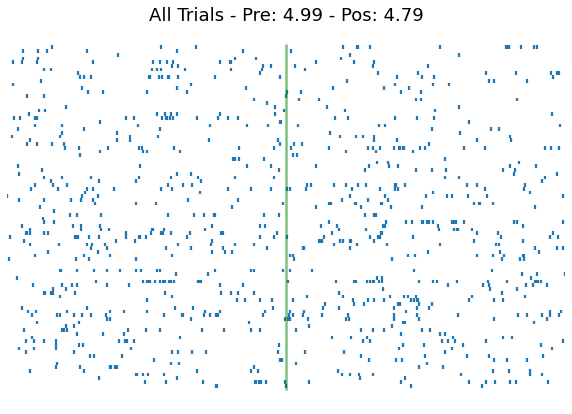

In [16]:
# Plot raster across 
plot_trial_rasters(all_trials, xlim=trial_range, figsize=(10, 7), 
                   title='All Trials - Pre: {:1.2f} - Pos: {:1.2f}'.format(fr_pre, fr_post))

## Stimuli

In [17]:
# Create masks to sub-select full & empty chests
empty_mask = chest_stimuli == 0
full_mask = chest_stimuli != 0

In [18]:
# Calculate how many full/empty chests there are
n_empty = sum(empty_mask)
n_full = sum(full_mask)

In [19]:
# Check how many full/empty chests there are
print('Number of empty chests: \t{}'.format(n_empty))
print('Number of full chests: \t\t{}'.format(n_full))

Number of empty chests: 	36
Number of full chests: 		60


In [20]:
#assert n_empty + n_full == n_chests

In [21]:
# Sub-select full & empty chest trials
empty_trials = select_from_list(all_trials, empty_mask)
full_trials = select_from_list(all_trials, full_mask)

In [22]:
# Calculate firing rate pre & post chest opening
fr_pre_e, fr_post_e = calc_trial_frs(empty_trials)
fr_pre_f, fr_post_f = calc_trial_frs(full_trials)

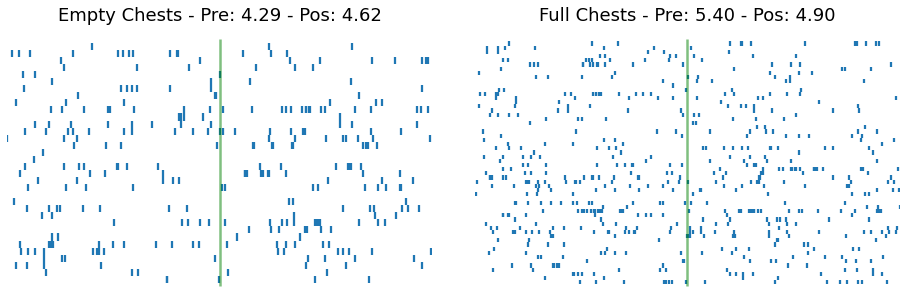

In [23]:
# Plot a comparison of full and empty trials
_, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_trial_rasters(empty_trials, xlim=trial_range, ax=axes[0], 
                   title='Empty Chests - Pre: {:1.2f} - Pos: {:1.2f}'.format(fr_pre_e, fr_post_e))
plot_trial_rasters(full_trials, xlim=trial_range, ax=axes[1],
                   title='Full Chests - Pre: {:1.2f} - Pos: {:1.2f}'.format(fr_pre_f, fr_post_f))
plt.subplots_adjust(wspace=0.1)

### Check All Cells

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_93989/316142725.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, axes = plt.subplots(1, 2, figsize=(16, 5))


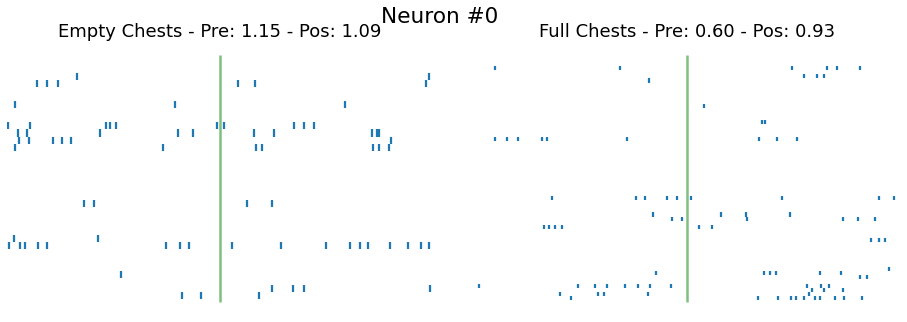

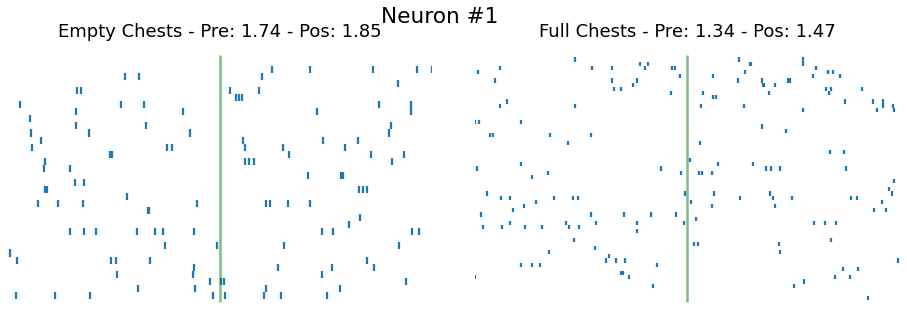

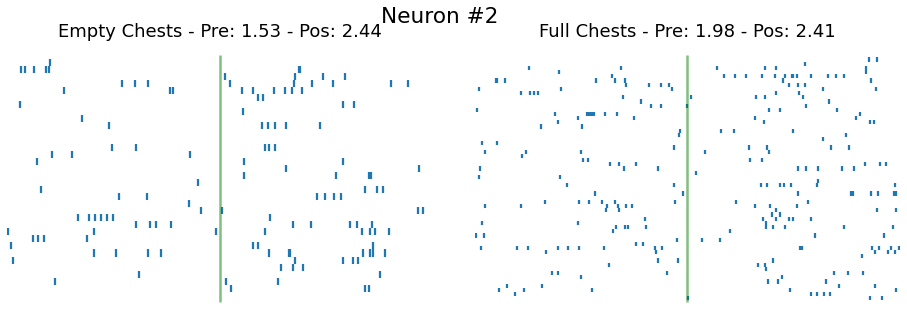

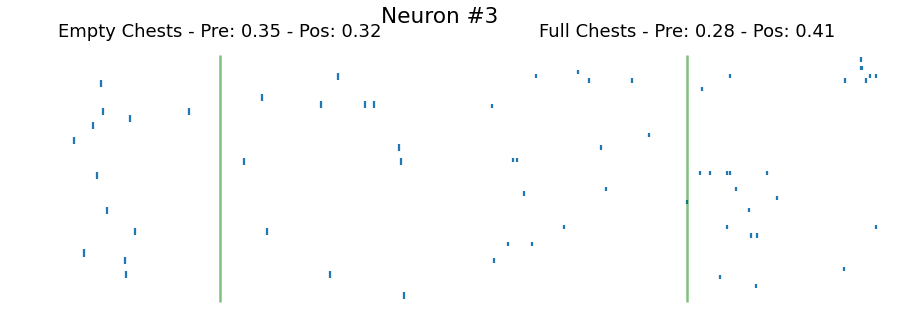

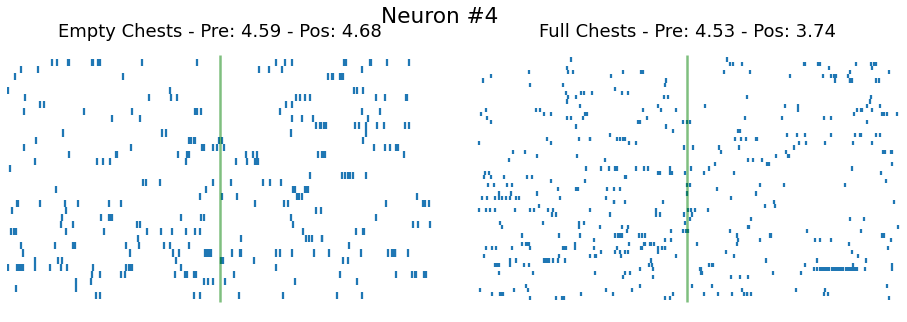

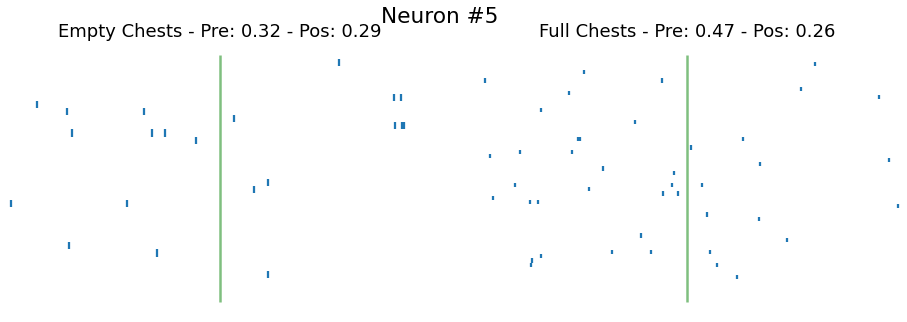

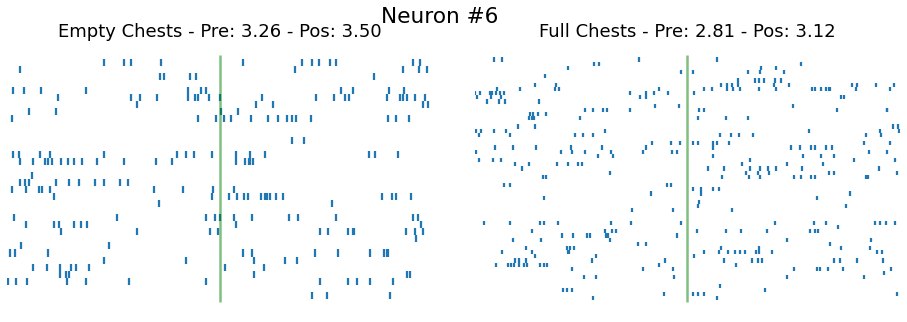

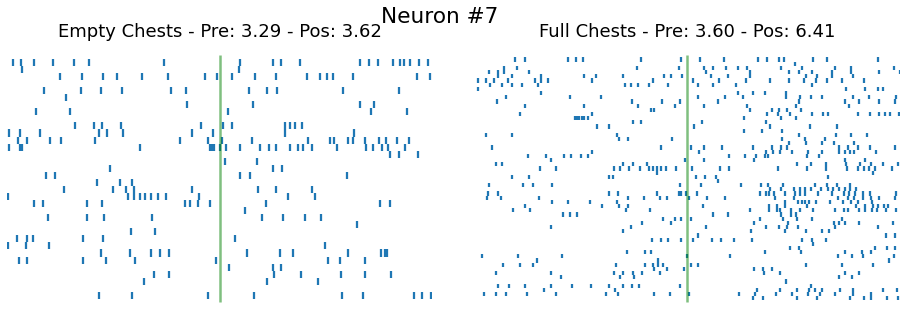

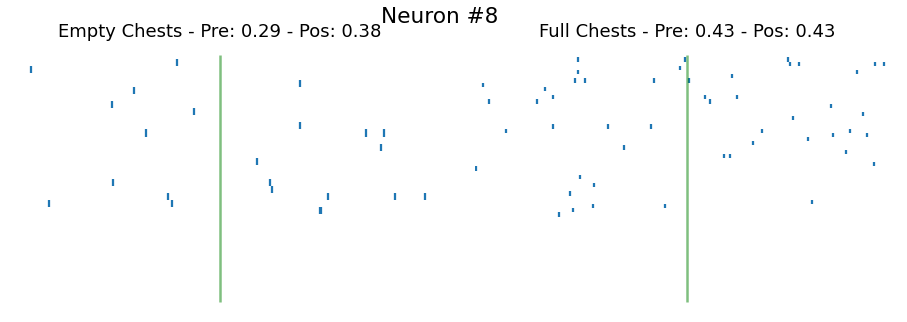

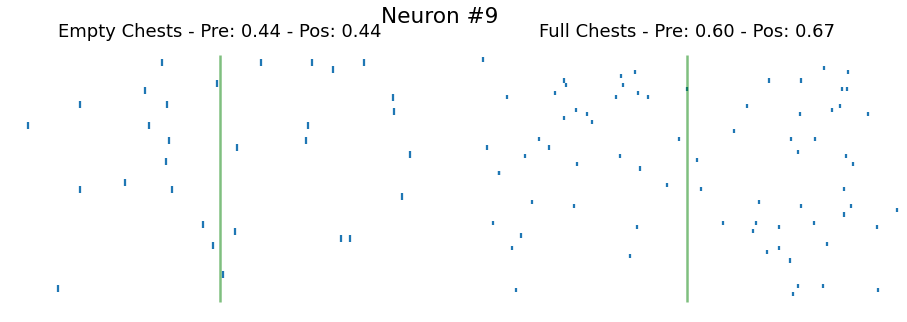

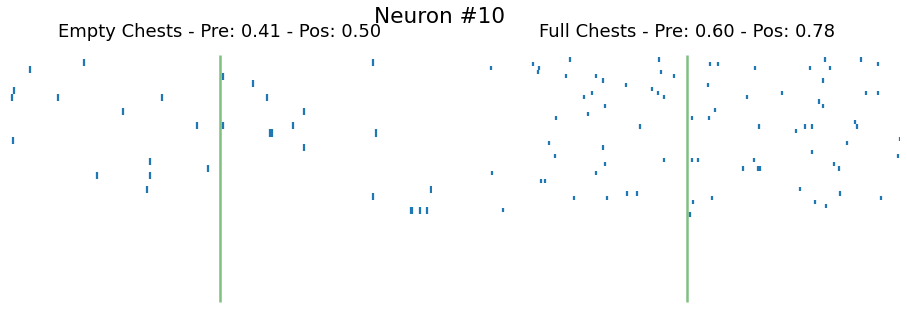

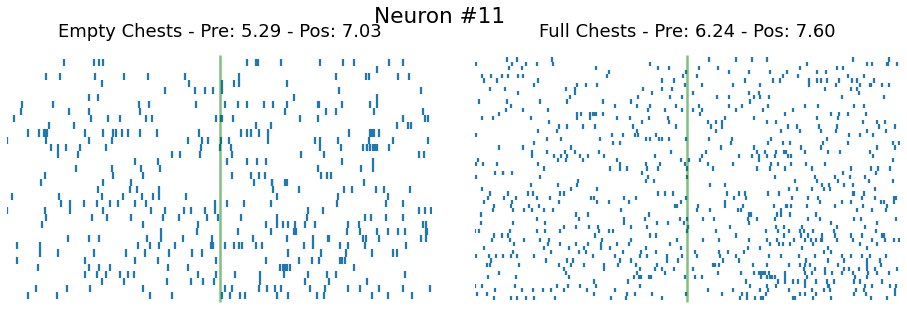

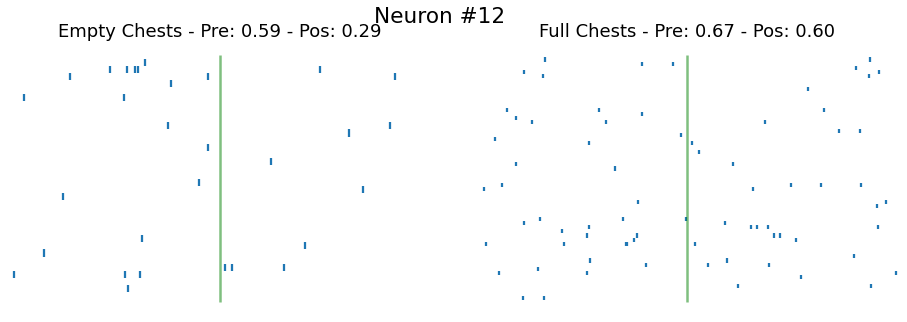

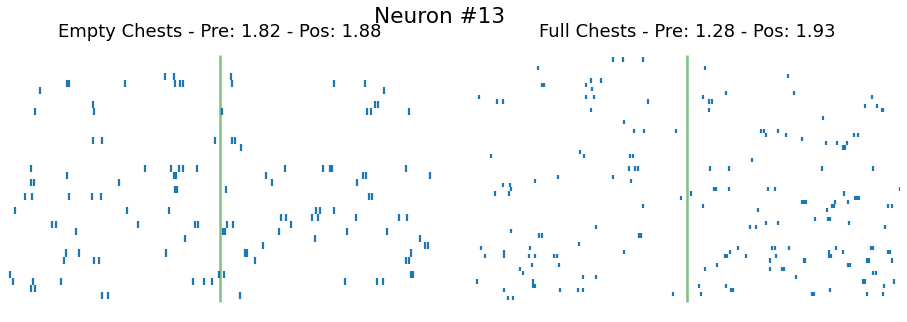

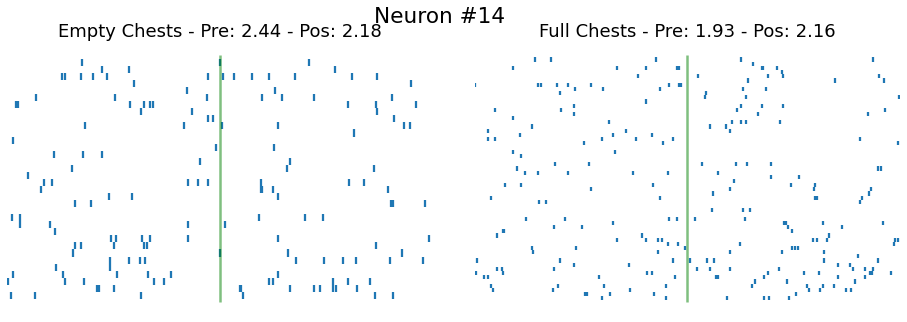

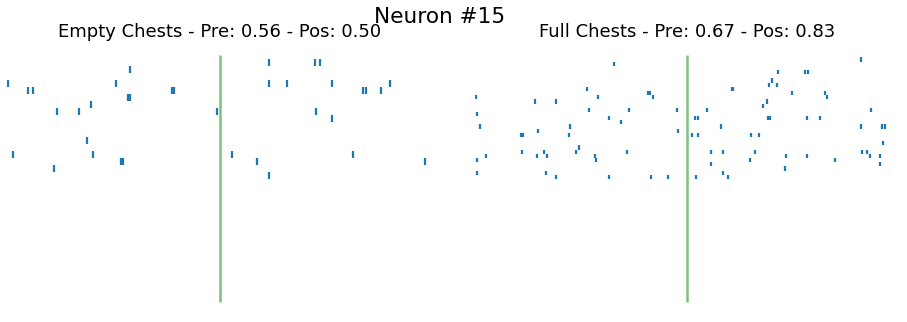

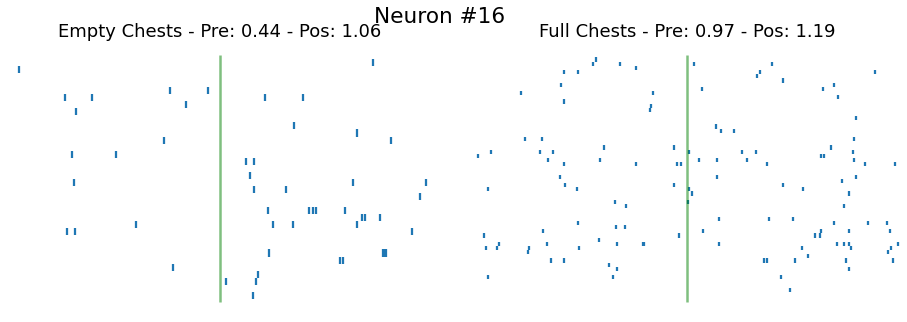

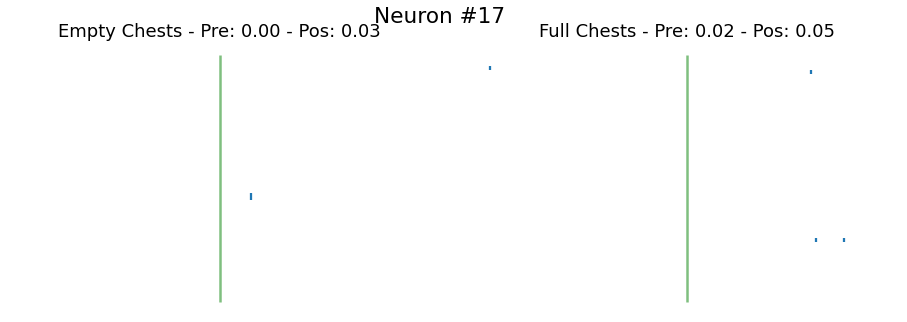

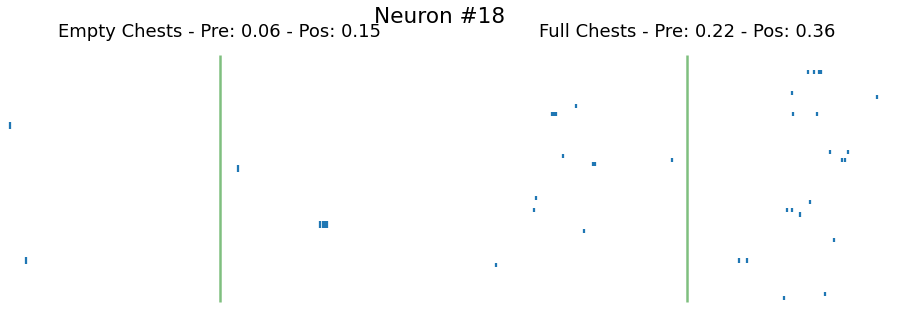

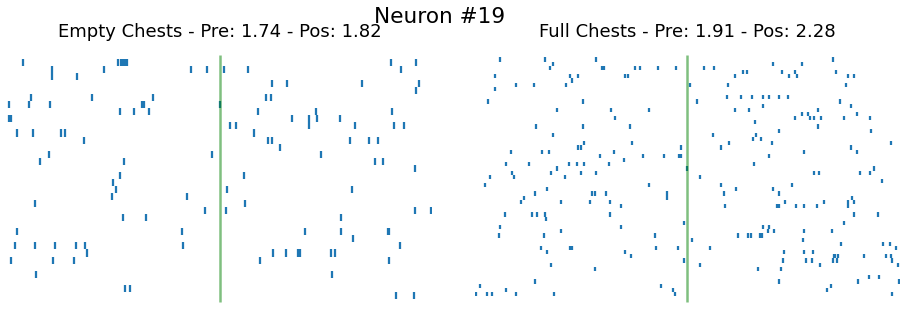

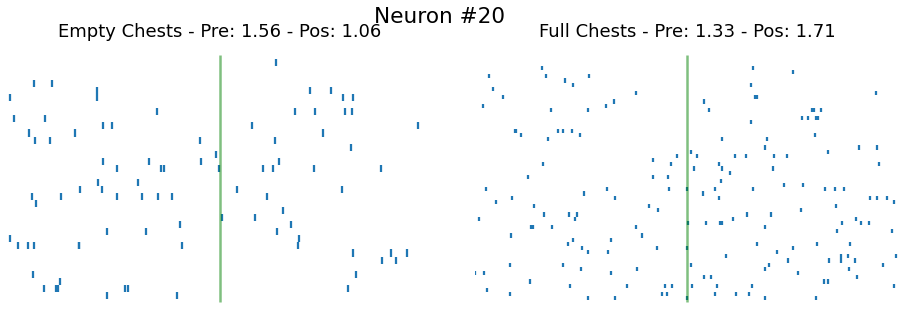

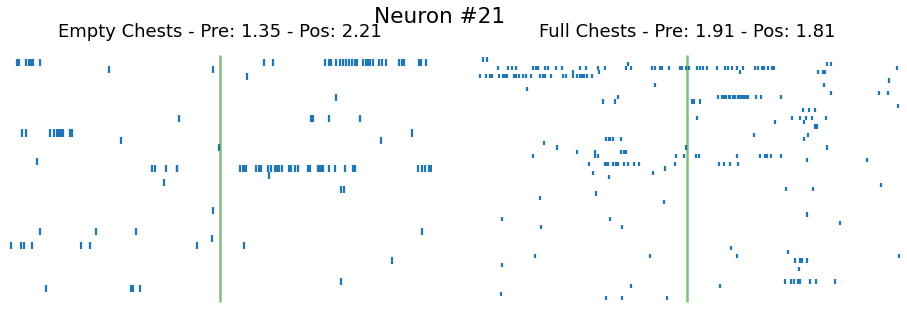

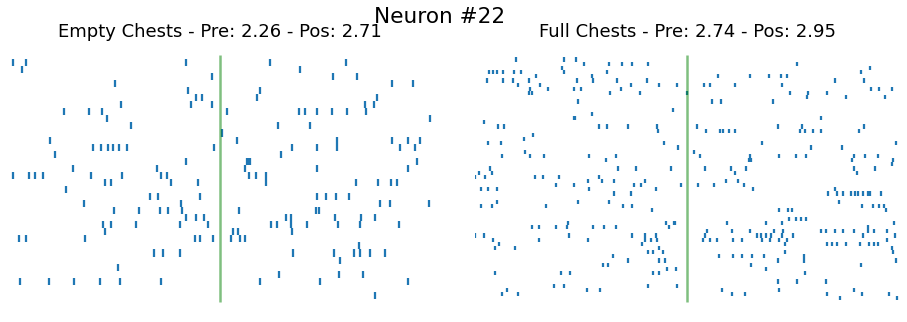

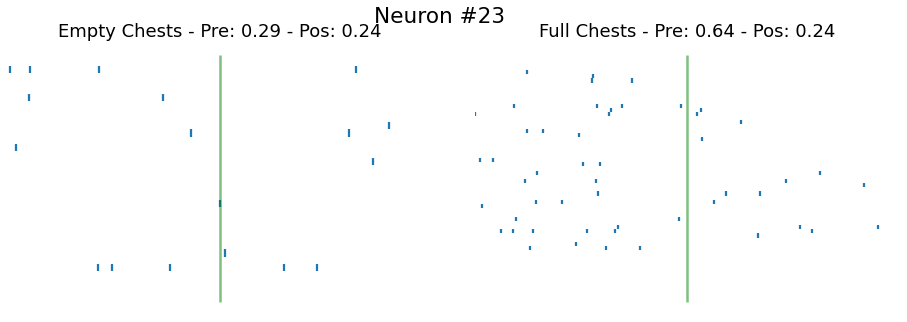

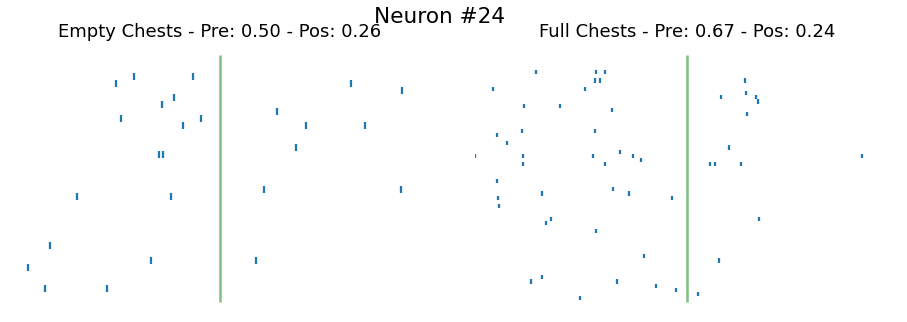

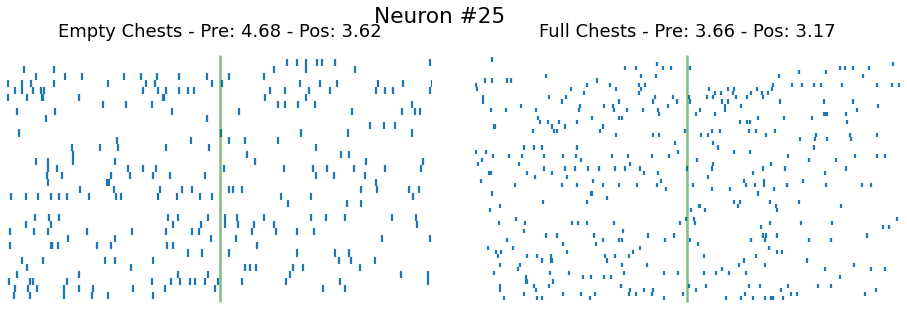

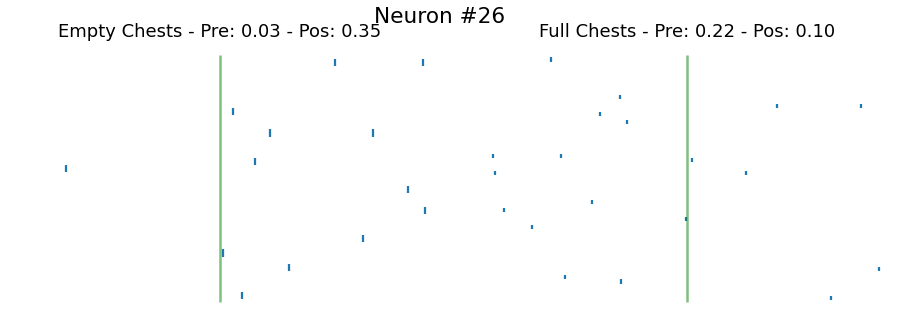

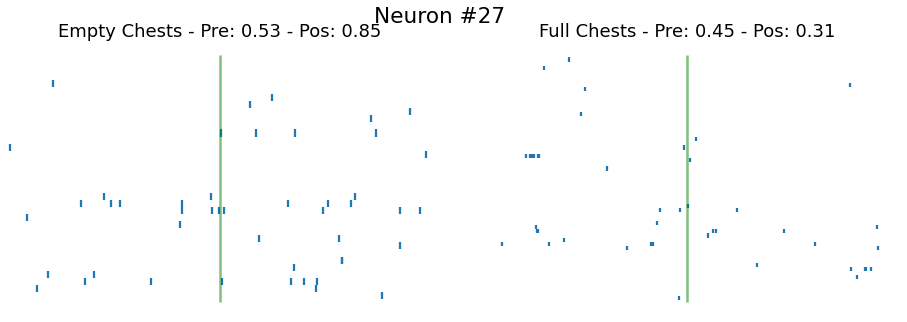

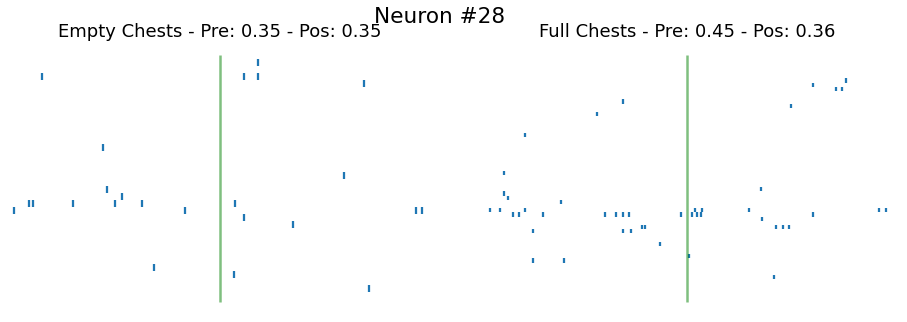

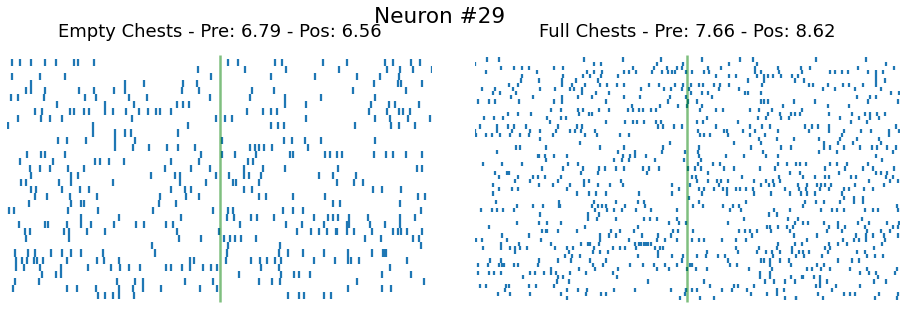

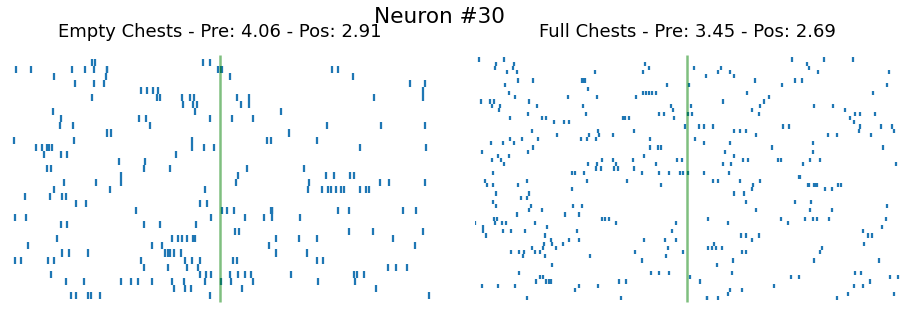

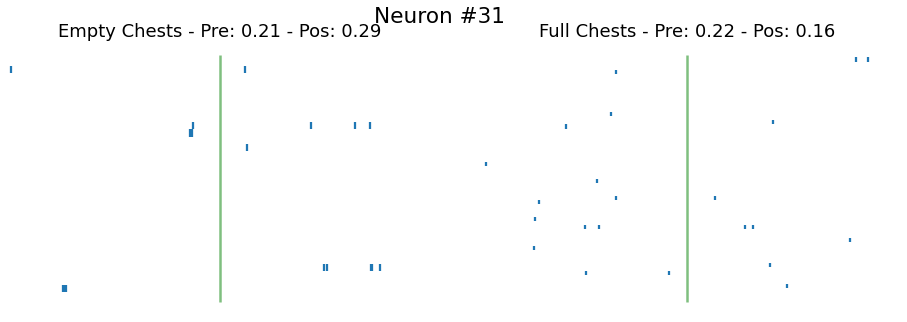

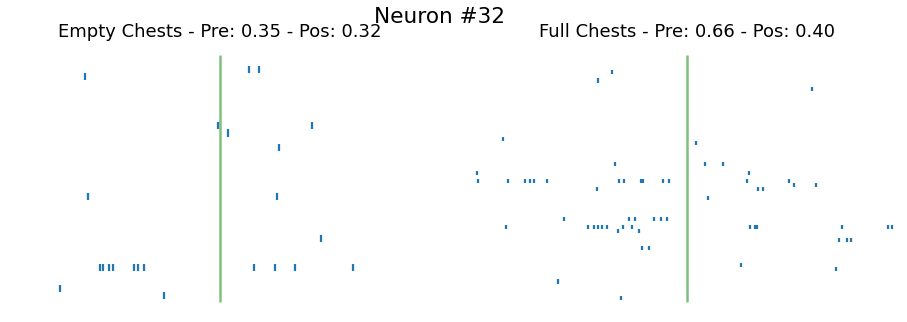

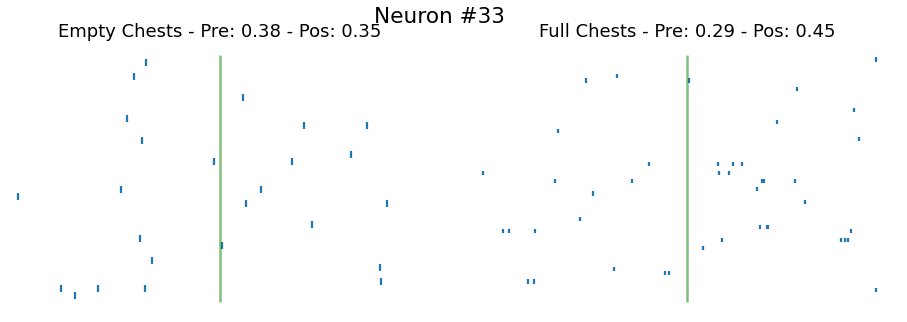

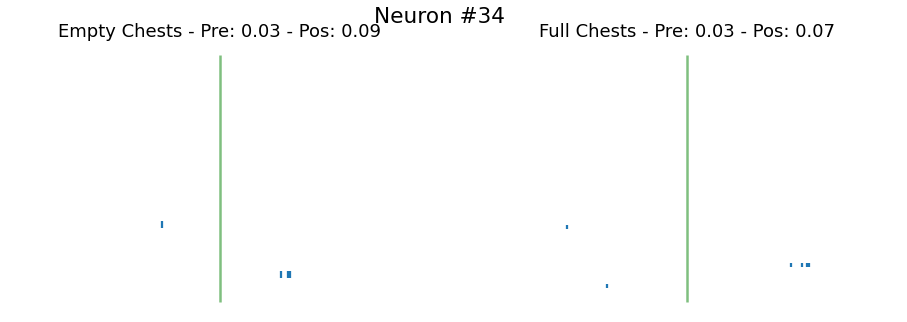

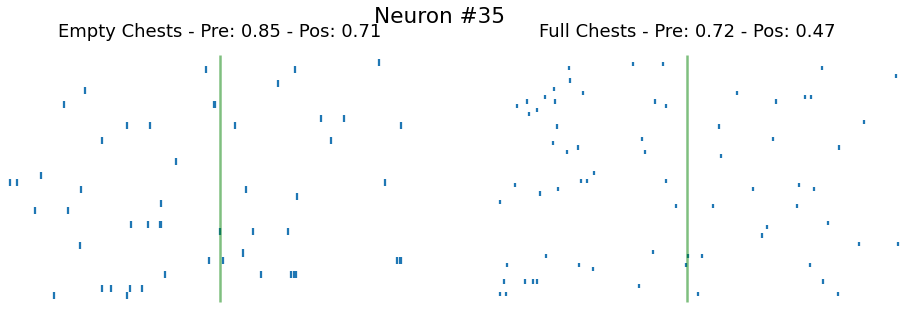

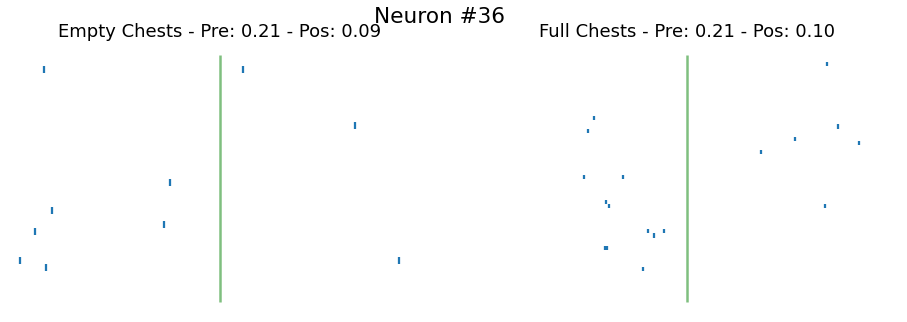

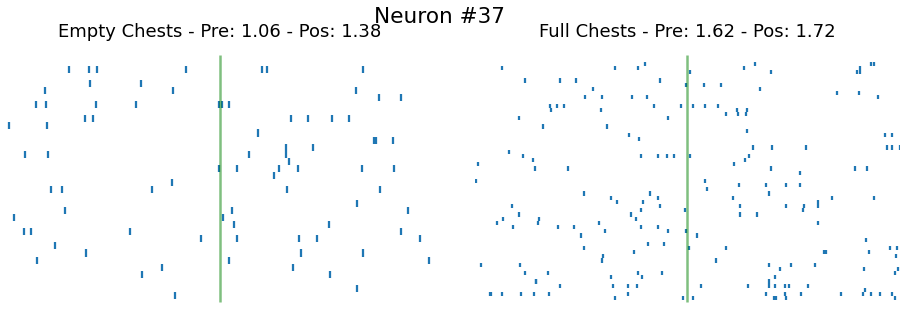

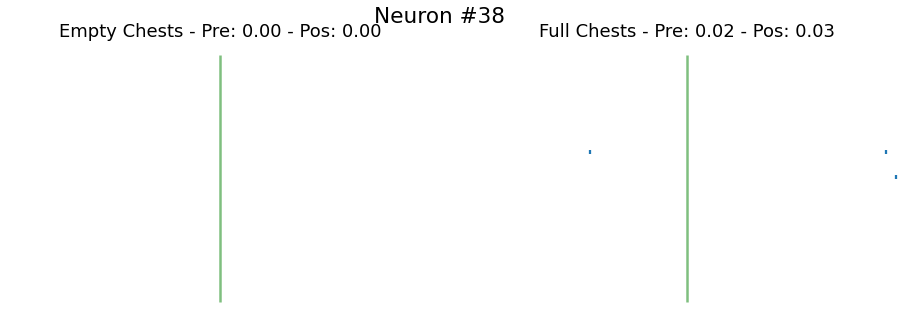

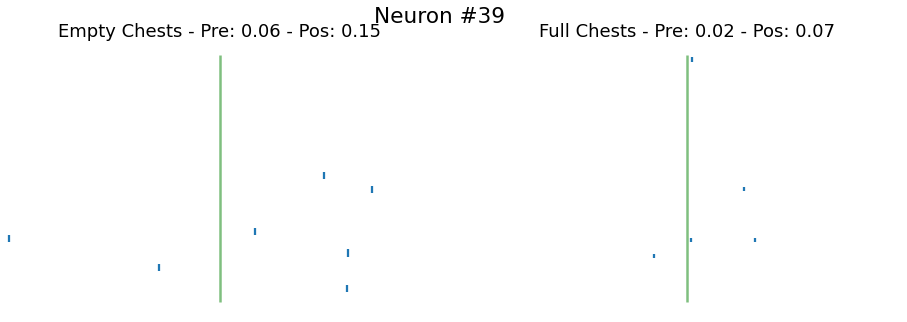

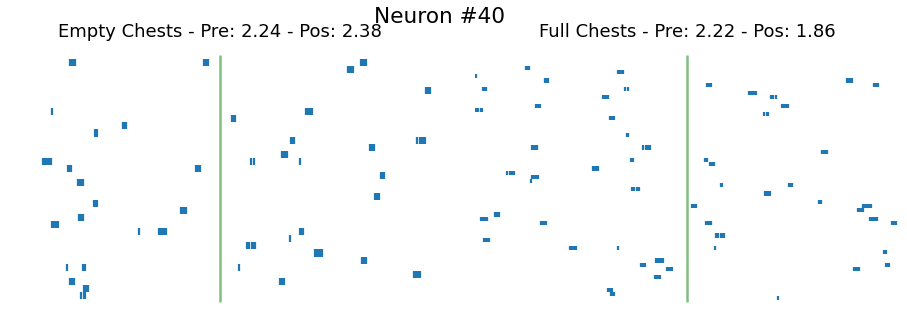

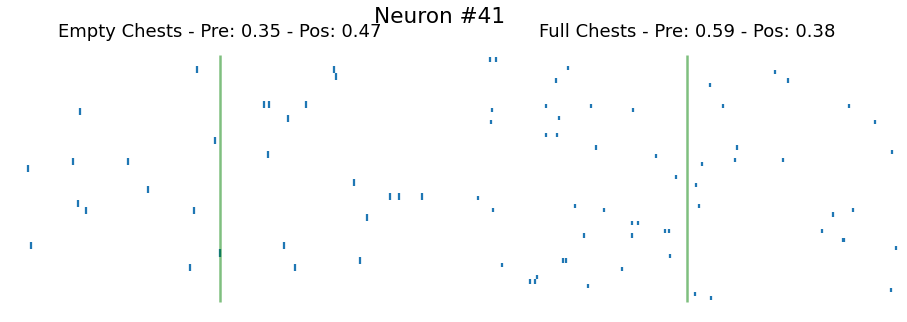

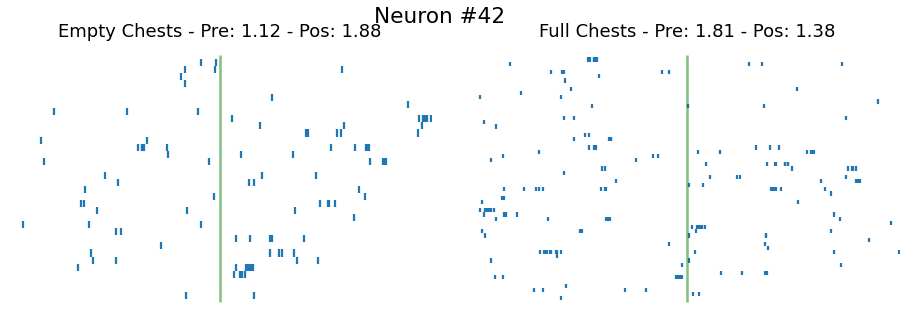

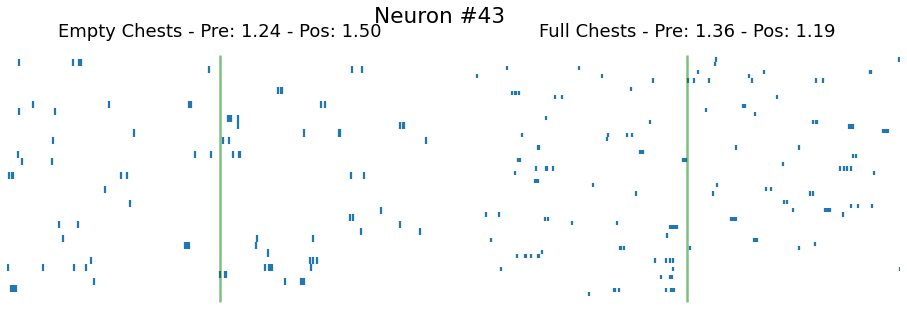

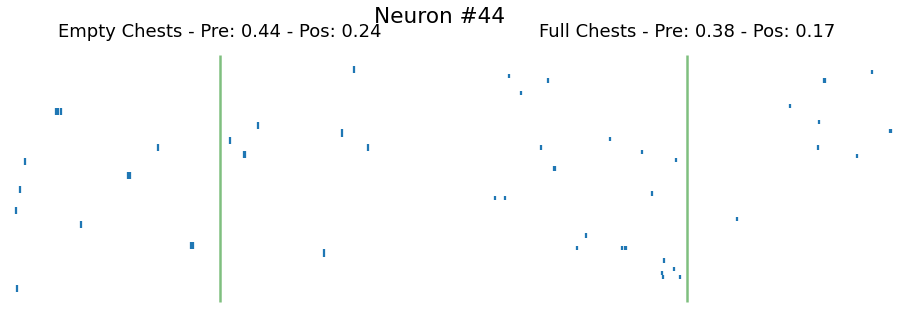

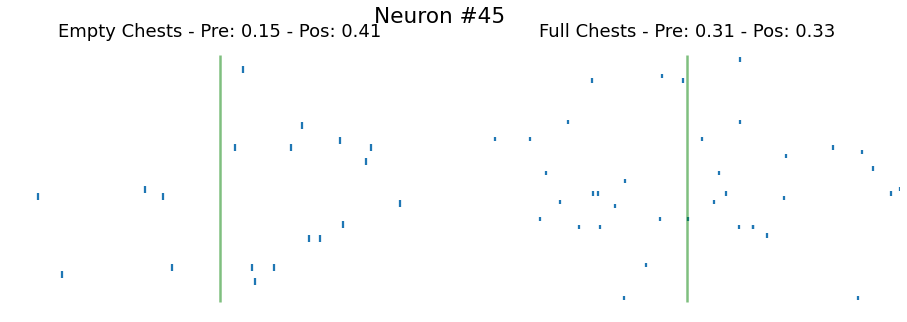

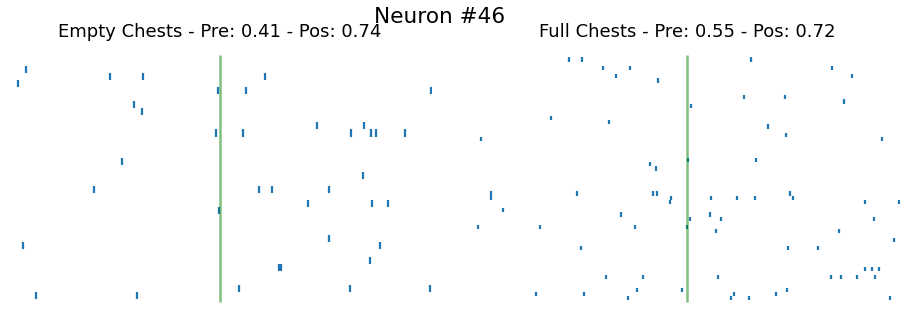

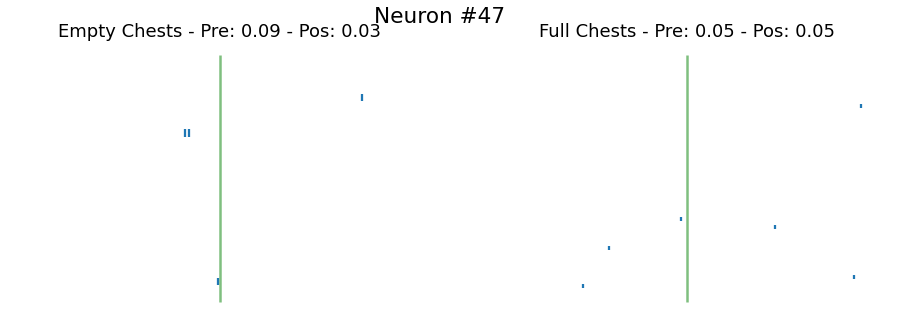

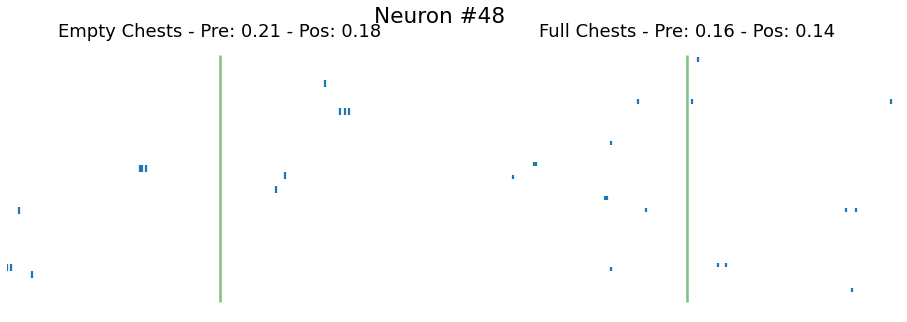

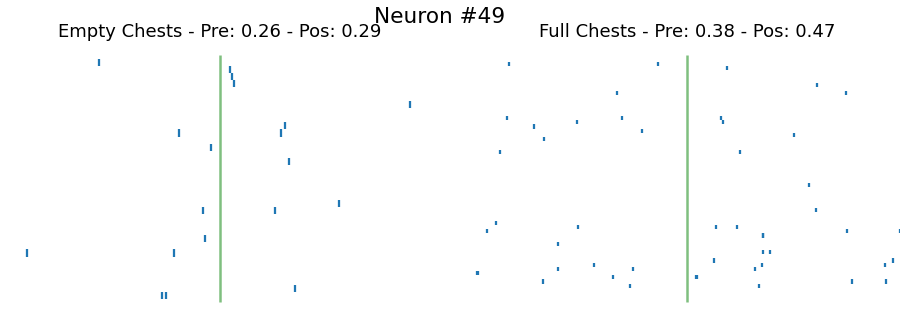

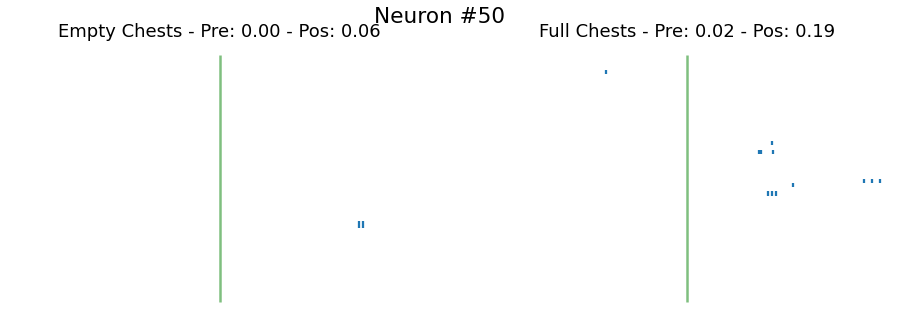

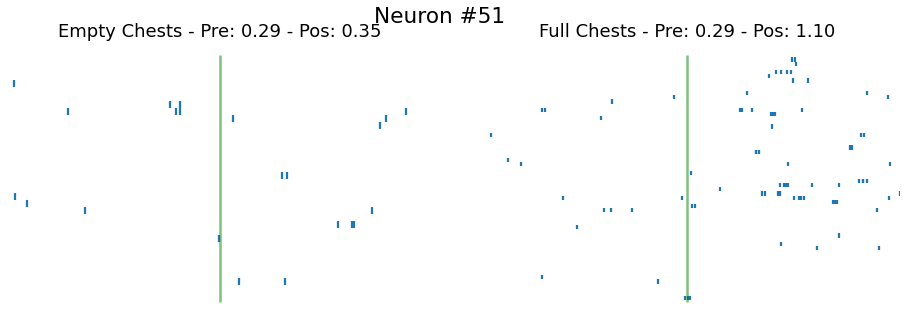

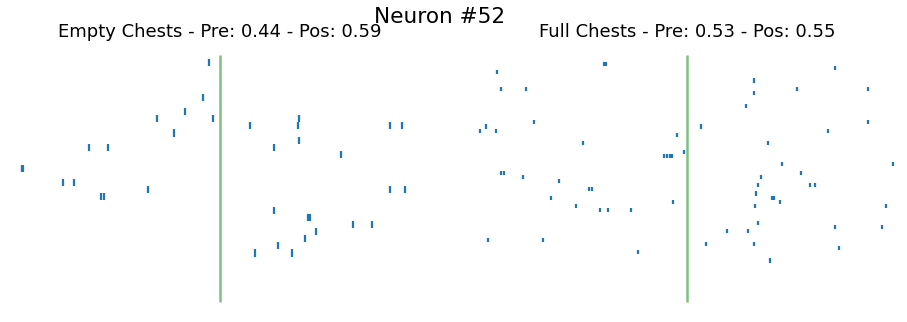

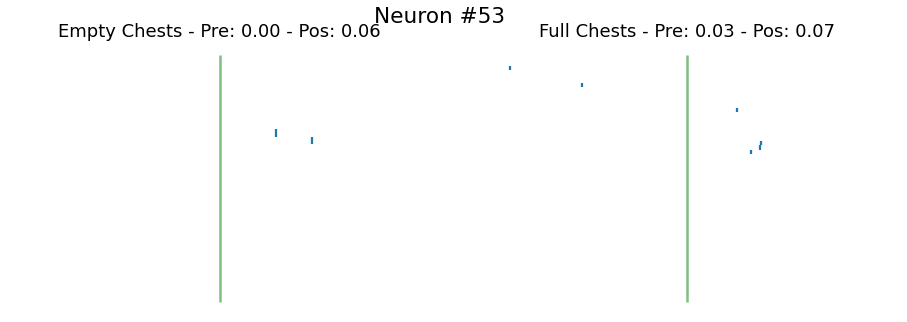

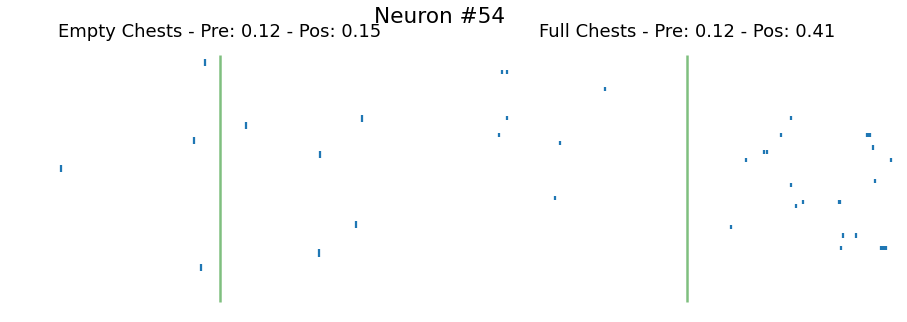

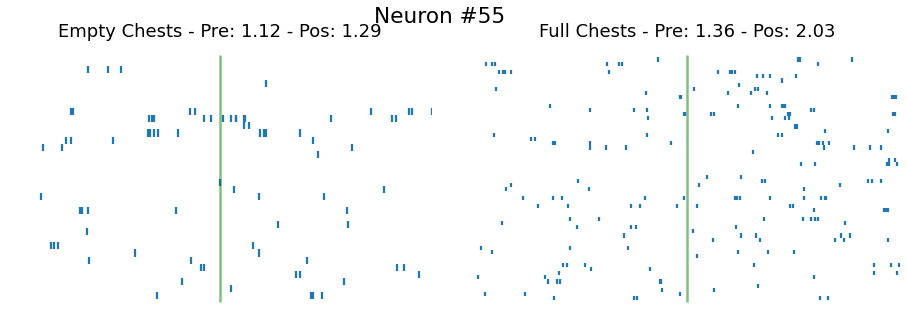

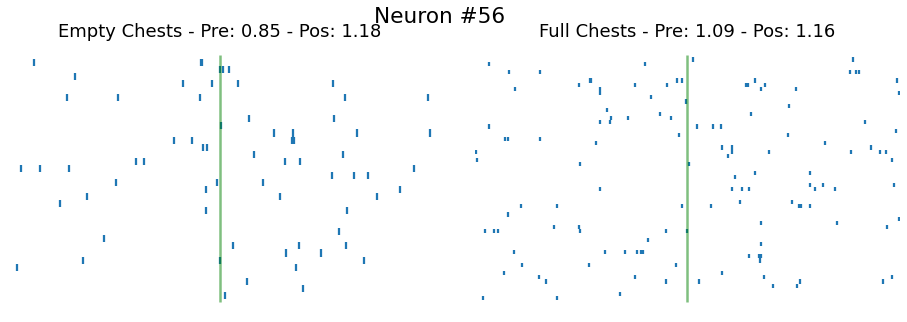

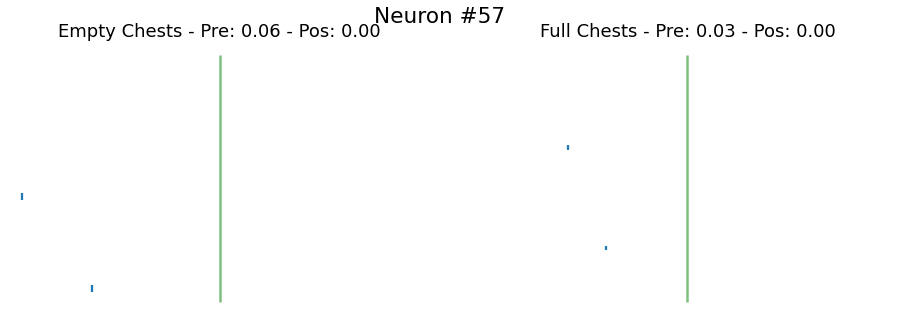

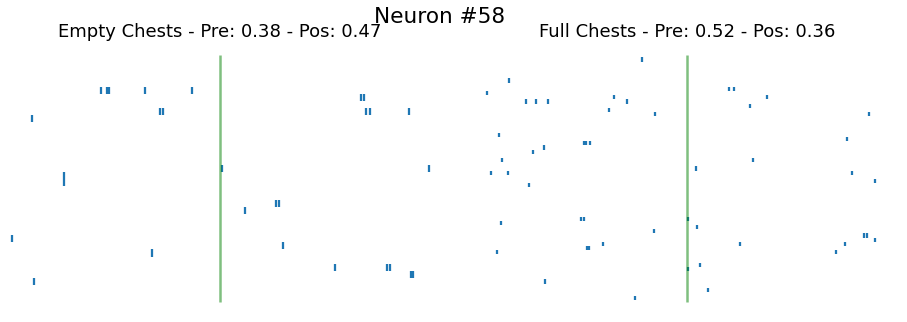

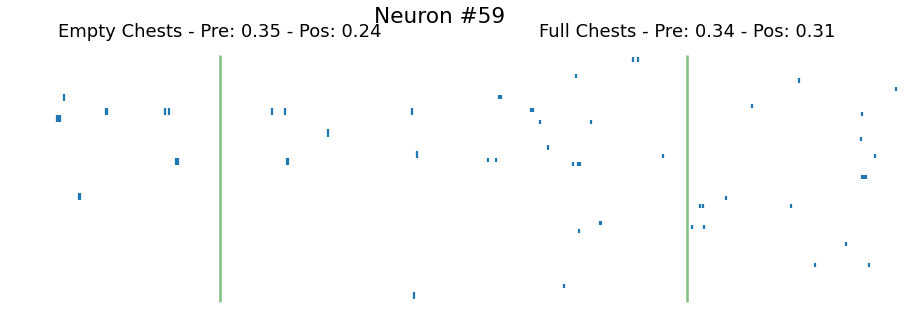

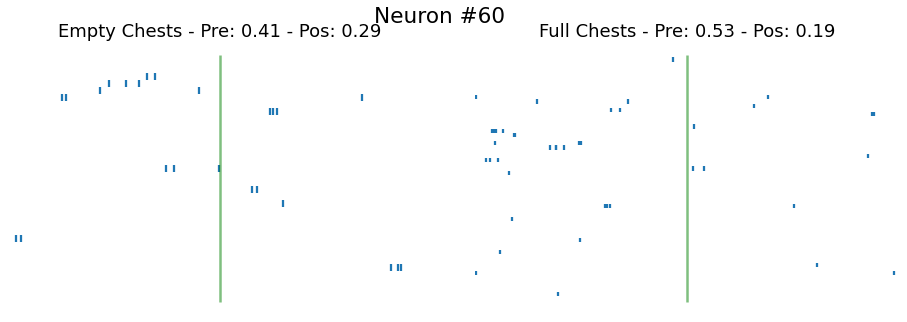

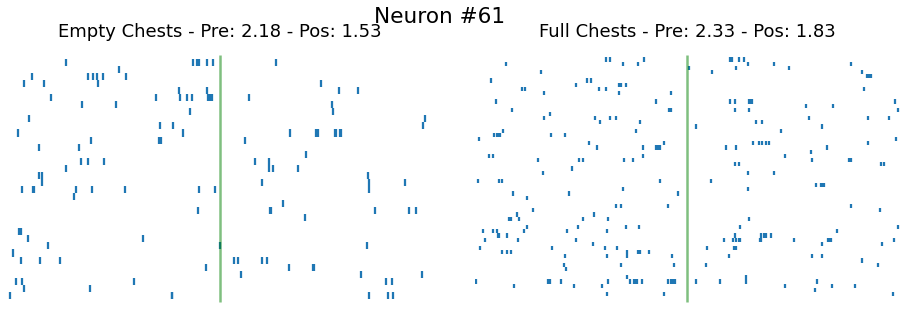

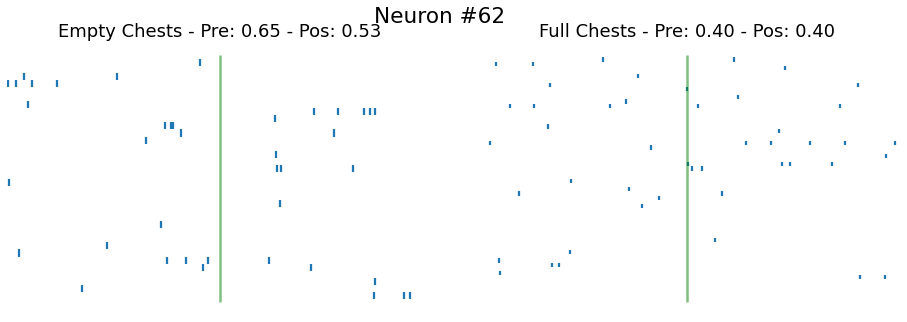

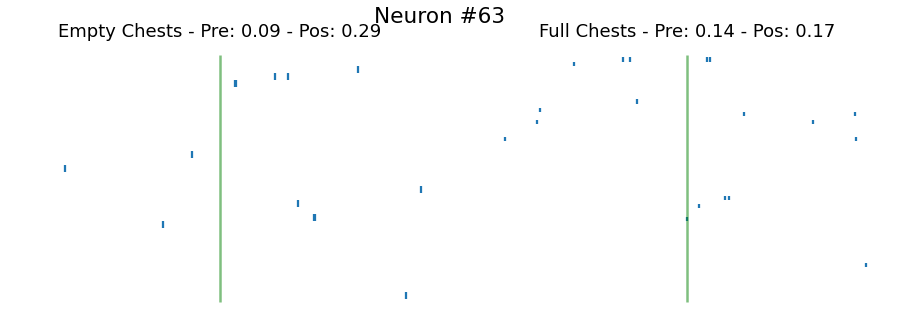

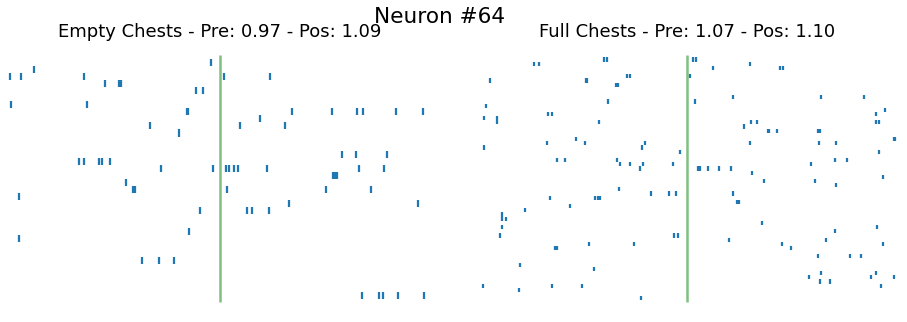

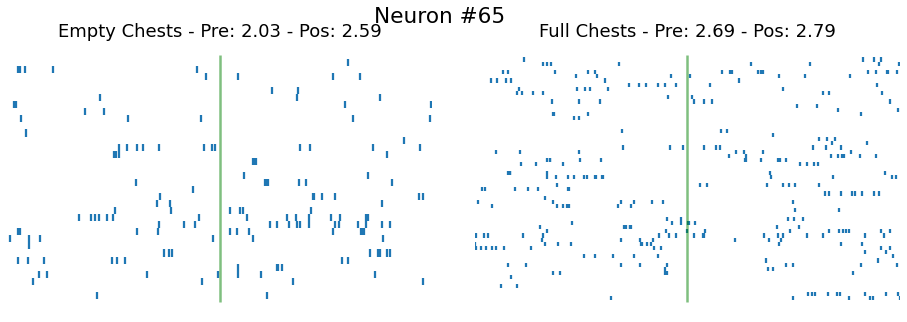

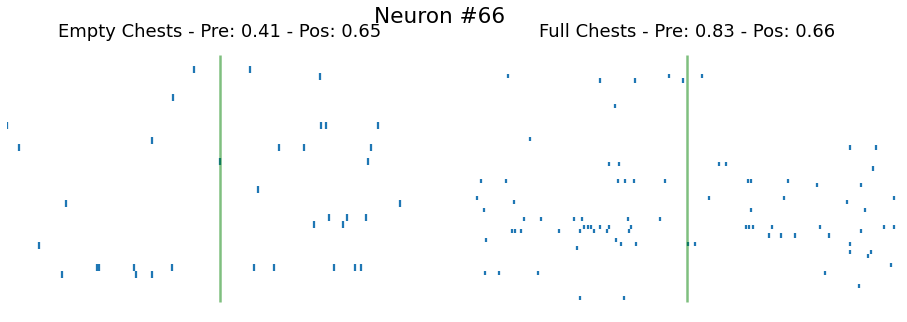

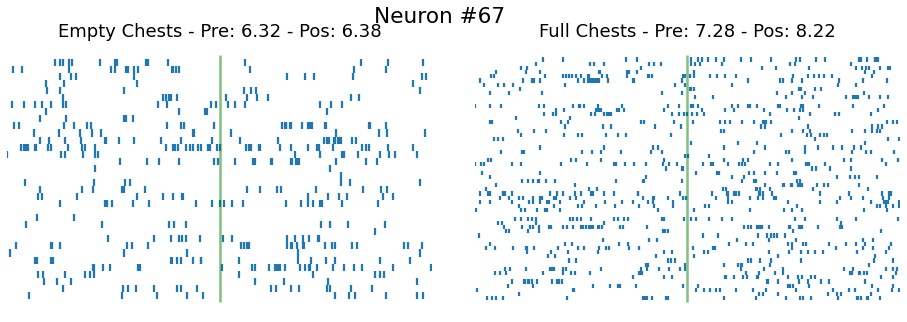

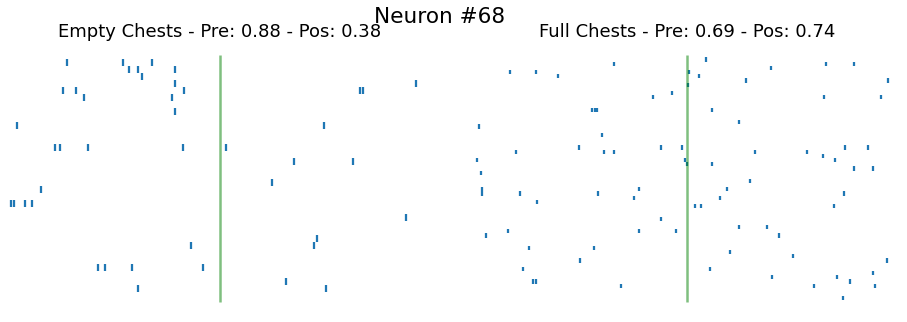

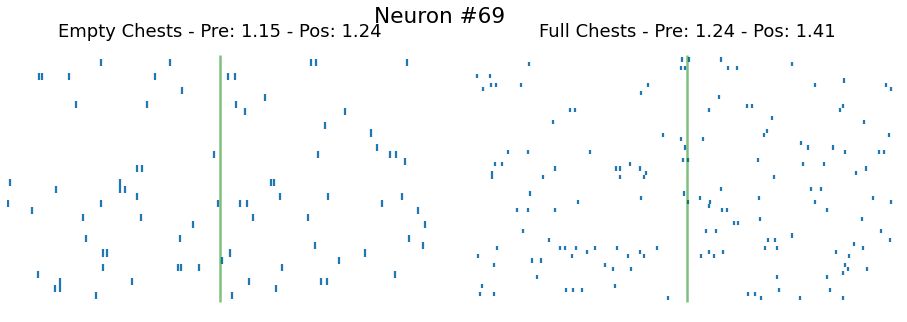

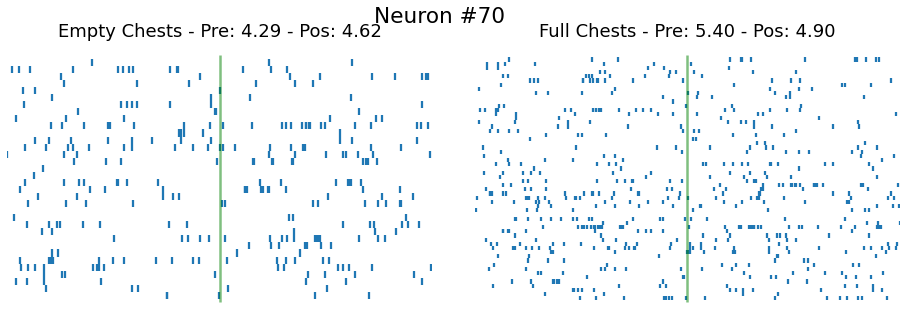

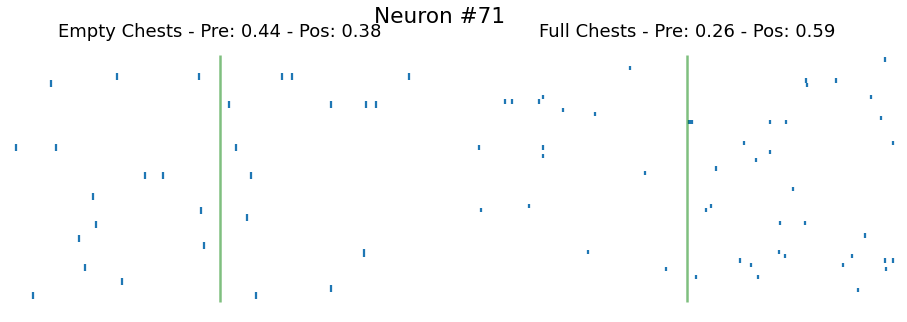

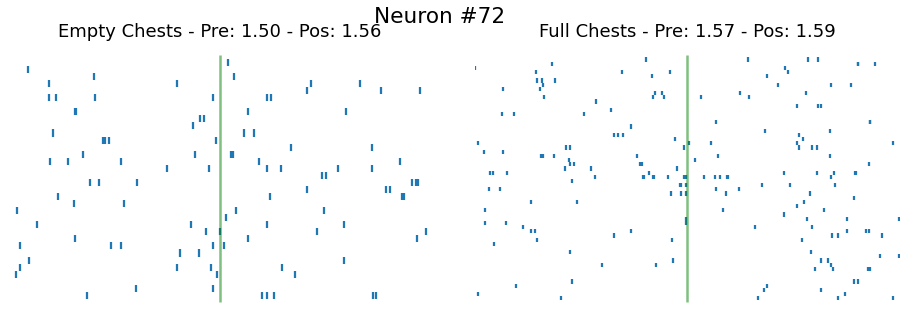

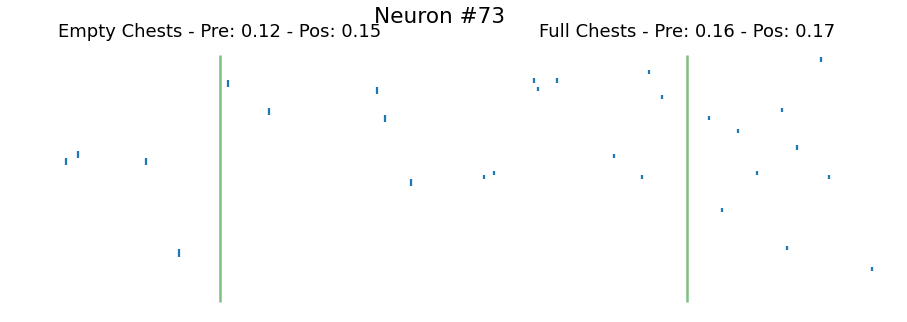

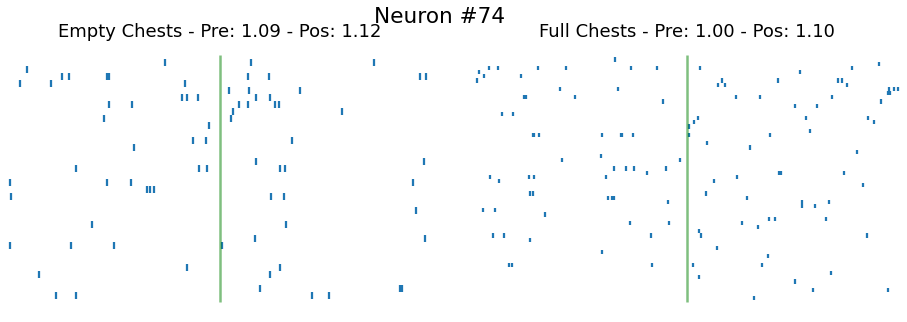

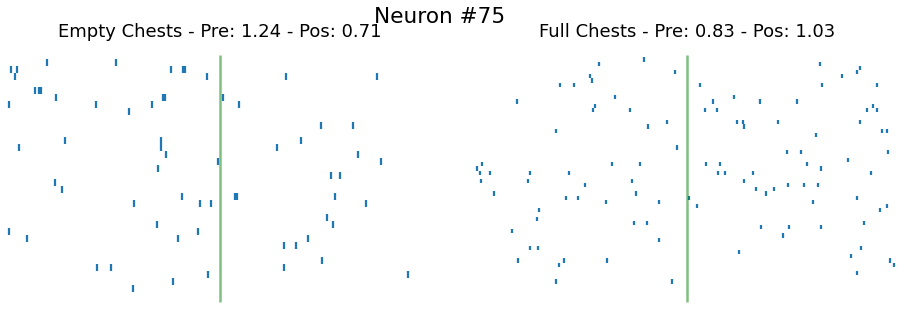

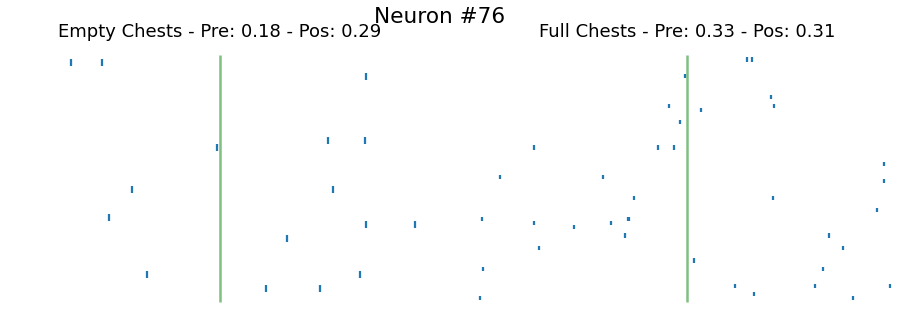

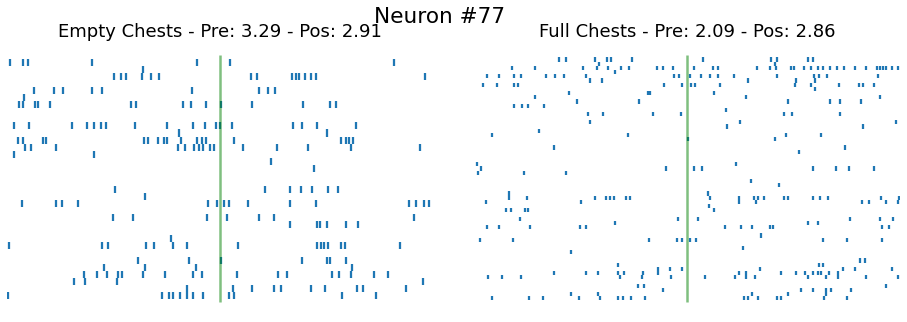

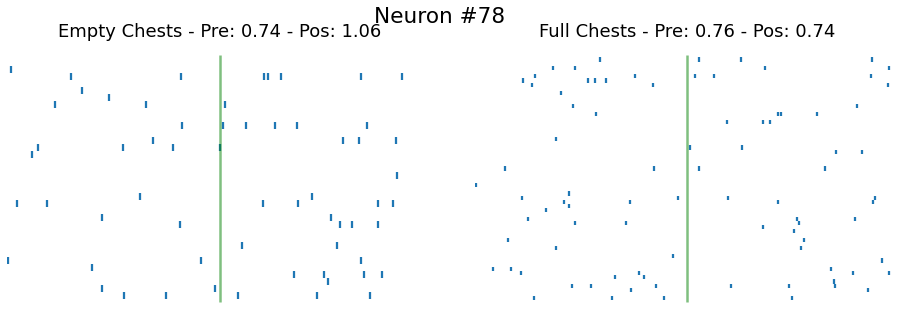

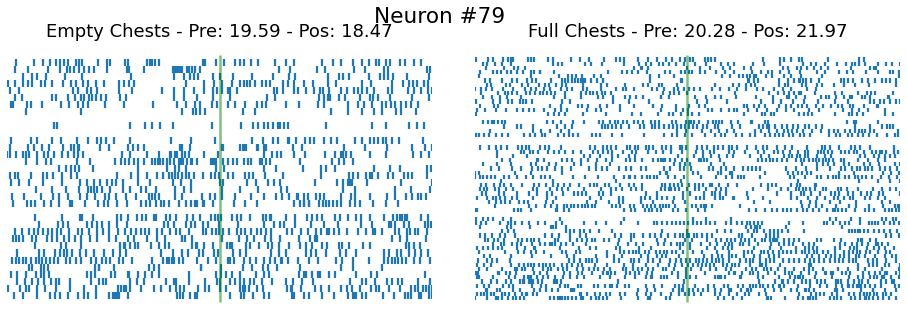

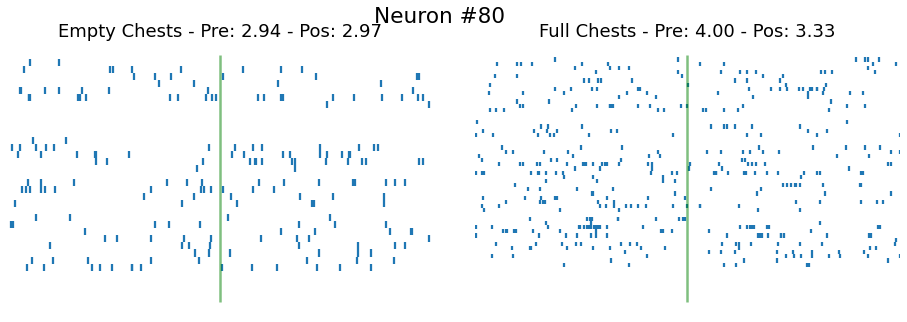

In [24]:
for uind in range(n_units):

    spikes = nwbfile.units.get_unit_spike_times(uind) / 1000
    
    all_trials = []
    for opening in openings:
        all_trials.append(restrict_range(spikes, opening + trial_range[0], opening + trial_range[1]) - opening)    
    
    # Plot all trials together
    #plot_trial_rasters(all_trials, xlim=trial_range, figsize=(10, 7))

    # Plot separate rasters for full and empty trials
    _, axes = plt.subplots(1, 2, figsize=(16, 5))
    empty_trials = select_from_list(all_trials, empty_mask)
    plot_trial_rasters(empty_trials, xlim=trial_range, 
                       title='Empty Chests - Pre: {:1.2f} - Pos: {:1.2f}'.format(*calc_trial_frs(empty_trials)),
                       ax=axes[0])
    full_trials = select_from_list(all_trials, full_mask)
    plot_trial_rasters(full_trials, xlim=trial_range,
                       title='Full Chests - Pre: {:1.2f} - Pos: {:1.2f}'.format(*calc_trial_frs(full_trials)),
                       ax=axes[1])
    plt.subplots_adjust(wspace=0.1)
    plt.suptitle('Neuron #{}'.format(uind))